Warp 1.6.0 initialized:
   CUDA Toolkit 12.8, Driver 12.4
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA L4" (22 GiB, sm_89, mempool enabled)
   Kernel cache:
     /home/nishadgothoskar/.cache/warp/1.6.0
Video has 426 frames


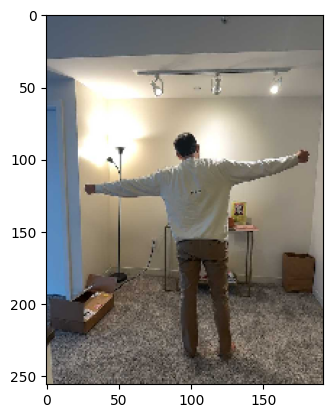

In [1]:
import condorgmm
import warp as wp
wp.init()
from condorgmm.utils.common import get_assets_path
import condorgmm.data as data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import warp as wp
from condorgmm.warp_gmm.adam import Adam
from condorgmm.warp_gmm.state import State
import importlib

# video = data.R3DVideo(get_assets_path() / "peace-string.r3d")
video = data.R3DVideo(get_assets_path() / "condorgmm_bucket/finger.r3d")
video = data.R3DVideo(get_assets_path() / "condorgmm_bucket/person.r3d")

# Config for nearfar
# frame_idxs = range(0, len(video), 1)
# video = video.crop(50, 180, 50, 256)

# fig, ax = plt.subplots()
# def update(idx):
#     ax.clear()
#     ax.imshow(video[frame_idxs[idx]].rgb)
#     ax.set_title(f"Frame {frame_idxs[idx]}")

# ani = FuncAnimation(fig, update, len(frame_idxs), repeat=False)
# HTML(ani.to_jshtml())
frame = video[0]
print("Video has", len(video), "frames")
plt.imshow(frame.rgb)

-874348.4


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:10<00:00, 99.89it/s]


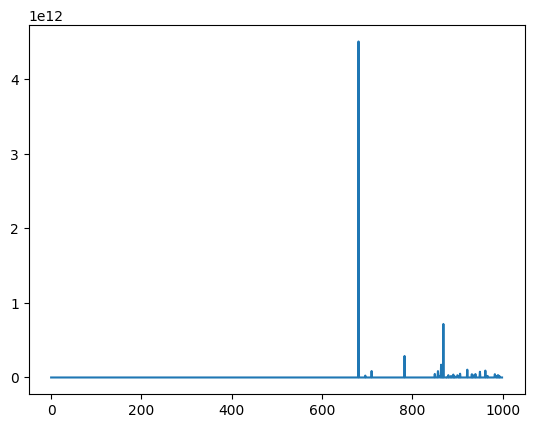

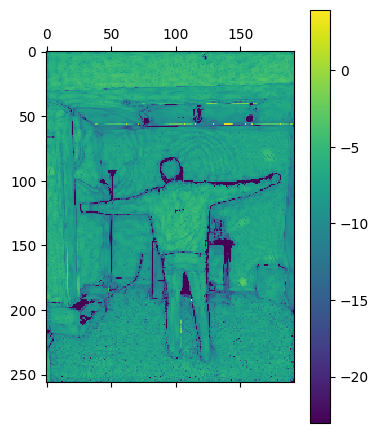

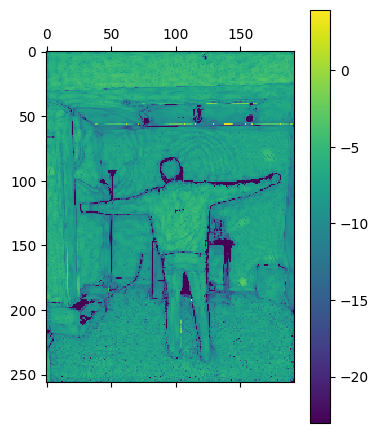

In [4]:
import condorgmm.warp_gmm as warp_gmm
import condorgmm.warp_gmm.kernels

from tqdm import tqdm
condorgmm.rr_init("deforamble_fitting")

frame = video[0]
frame_warp = frame.as_warp()

# mask_np = (frame.rgb > 0.85).all(axis=-1)


STRIDE = 8
spatial_means = np.array(
    condorgmm.xyz_from_depth_image(frame.depth, *frame.intrinsics)[::STRIDE, ::STRIDE, :].reshape(-1,3),
    dtype=np.float32
)
rgb_means = np.array(frame.rgb[::STRIDE, ::STRIDE, :].reshape(-1, 3), dtype=np.float32)
log_rgb_scales = np.array(np.log(np.ones_like(rgb_means) * 10.0), dtype=np.float32)

gmm =  warp_gmm.gmm_warp_from_numpy(
    spatial_means=spatial_means,
    rgb_means=rgb_means,
    log_rgb_scales=log_rgb_scales,
)
warp_gmm_state = warp_gmm.initialize_state(gmm=gmm, frame=frame)
warp_gmm_state.hyperparams.window_half_width = 20
warp_gmm_state.hyperparams.outlier_volume = 1e6
warp_gmm_state.hyperparams.outlier_probability = 0.0001

condorgmm.rr_set_time(0)
warp_gmm.rr_log_gmm_warp(warp_gmm_state.gmm, "gmm_warp", size_scalar=1.0)
condorgmm.rr_log_frame(video[0])

warp_gmm_state.gmm.spatial_means.requires_grad = True
warp_gmm_state.gmm.quaternions_imaginary.requires_grad = True
warp_gmm_state.gmm.quaternions_real.requires_grad = True
warp_gmm_state.gmm.rgb_means.requires_grad = True
warp_gmm_state.gmm.log_spatial_scales.requires_grad = True
params_to_optimize = [warp_gmm_state.gmm.spatial_means, warp_gmm_state.gmm.log_spatial_scales,
                      warp_gmm_state.gmm.rgb_means,
                      warp_gmm_state.gmm.quaternions_imaginary, warp_gmm_state.gmm.quaternions_real]
from condorgmm.warp_gmm.adam import Adam as Adam2
optimizer = Adam2(params_to_optimize, lr=[5e-4, 1e-2, 1e-2, 1e-2,
                                          1e-2], betas=(0.9, 0.9995))

T =0
frame_warp = video[T].as_warp()

condorgmm.warp_gmm.kernels.warp_gmm_forward(frame_warp, warp_gmm_state)
print(warp_gmm_state.log_score_image.numpy().sum())

scores = []
for t in tqdm(range(1000)):
    condorgmm.rr_set_time(t)

    tape = wp.Tape()
    with tape:
        condorgmm.warp_gmm.kernels.warp_gmm_forward(
            frame_warp,
            warp_gmm_state,
        )

    # condorgmm.warp_gmm.kernels.warp_gmm_forward(frame_warp, warp_gmm_state)
    # likelihood = warp_gmm_state.log_score_image.numpy().sum()
    # likelihood_over_time.append(likelihood)
    # pbar.set_description(f"Log score: {likelihood}")
    tape.backward(grads={warp_gmm_state.log_score_image: wp.ones_like(warp_gmm_state.log_score_image)})
    optimizer.step([x.grad for x in params_to_optimize])
    tape.zero()
    wp.synchronize()

    score = warp_gmm_state.log_score_image.numpy().sum()
    scores.append(score)

    # warp_gmm.rr_log_gmm_warp(warp_gmm_state.gmm, "gmm_warp", size_scalar=1.0)
    # plt.matshow(warp_gmm_state.log_score_image.numpy())
    # condorgmm.rr_log_frame(video[T])

plt.plot(scores)

warp_gmm.warp_gmm_forward(frame_warp, warp_gmm_state)
plt.matshow(warp_gmm_state.log_score_image.numpy())
plt.colorbar()

warp_gmm.rr_log_gmm_warp(warp_gmm_state.gmm, "gmm_warp", size_scalar=1.0)
warp_gmm.warp_gmm_forward(frame_warp, warp_gmm_state)
plt.matshow(warp_gmm_state.log_score_image.numpy())
plt.colorbar()

In [3]:
# Optimize
condorgmm.rr_init("deforamble_tracking")
params_to_optimize = [warp_gmm_state.gmm.spatial_means, 
                    warp_gmm_state.gmm.quaternions_imaginary, warp_gmm_state.gmm.quaternions_real]
optimizer = Adam2(params_to_optimize, lr=[2e-4,
                                          1e-4,
                                          1e-4], betas=(0.9, 0.9995))

for T in tqdm(range(0, len(video), 5)):
    frame = video[T]
    frame_warp = frame.as_warp()

    for _ in tqdm(range(500)):

        tape = wp.Tape()
        with tape:
            condorgmm.warp_gmm.kernels.warp_gmm_forward(
                frame_warp,
                warp_gmm_state,
            )

        # condorgmm.warp_gmm.kernels.warp_gmm_forward(frame_warp, warp_gmm_state)
        # likelihood = warp_gmm_state.log_score_image.numpy().sum()
        # likelihood_over_time.append(likelihood)
        # pbar.set_description(f"Log score: {likelihood}")
        tape.backward(grads={warp_gmm_state.log_score_image: wp.ones_like(warp_gmm_state.log_score_image)})
        optimizer.step([x.grad for x in params_to_optimize])
        tape.zero()
        wp.synchronize()


    condorgmm.rr_set_time(T)
    condorgmm.rr_log_frame(video[T])
    warp_gmm.rr_log_gmm_warp(warp_gmm_state.gmm, "gmm_warp", size_scalar=2.0)


  0%|          | 0/86 [00:00<?, ?it/s]

  6%|▌         | 5/86 [01:39<26:50, 19.88s/it]


KeyboardInterrupt: 

In [ ]:
num_timesteps = 10
pbar = tqdm(range(num_timesteps)) if tqdm else range(num_timesteps)
for step in pbar:
    frame_warp = video[T].as_warp()
    tape = wp.Tape()
    with tape:
        condorgmm.warp_gmm.kernels.warp_gmm_forward(
            frame_warp,
            warp_gmm_state,
        )

    # condorgmm.warp_gmm.kernels.warp_gmm_forward(frame_warp, warp_gmm_state)
    # likelihood = warp_gmm_state.log_score_image.numpy().sum()
    # likelihood_over_time.append(likelihood)
    # pbar.set_description(f"Log score: {likelihood}")
    tape.backward(grads={warp_gmm_state.log_score_image: wp.ones_like(warp_gmm_state.log_score_image)})
    for x in params_to_optimize:
        print(x.grad.numpy().min(), x.grad.numpy().max())
    optimizer.step([x.grad for x in params_to_optimize])
    tape.zero()
    wp.synchronize()

    condorgmm.rr_set_time(T)
    condorgmm.warp_gmm.kernels.warp_gmm_forward(frame_warp, warp_gmm_state)
    warp_gmm.rr_log_gmm_warp(warp_gmm_state.gmm, "gmm_warp", size_scalar=1.0)
    print(warp_gmm_state.log_score_image.numpy().sum())
    # plt.matshow(warp_gmm_state.log_score_image.numpy())
    condorgmm.rr_log_frame(video[T])

    plt.imshow(warp_gmm_state.log_score_image.numpy())
    plt.colorbar()

In [ ]:
warp_gmm_state.gmm.quaternions_imaginary.numpy()

In [ ]:
warp_gmm_state.gmm.quaternions_imaginary.numpy()

In [ ]:

import condorgmm.warp_gmm.kernels
from tqdm import tqdm
warp_gmm_state.gmm.spatial_means.requires_grad = True
warp_gmm_state.gmm.quaternions_imaginary.requires_grad = True
warp_gmm_state.gmm.quaternions_real.requires_grad = True
warp_gmm_state.gmm.rgb_means.requires_grad = True
params_to_optimize = [warp_gmm_state.gmm.spatial_means, warp_gmm_state.gmm.quaternions_imaginary, warp_gmm_state.gmm.quaternions_real]
optimizer = Adam(params_to_optimize, lr=[1e-6, 1e-6, wp.array([1e-6],dtype=wp.float32)], betas=(0.9, 0.9995))

for T in range(50):
    frame_warp = video[T].as_warp()

    condorgmm.warp_gmm.kernels.warp_gmm_forward(frame_warp, warp_gmm_state)
    print(warp_gmm_state.log_score_image.numpy().sum())

    likelihood_over_time = []

    num_timesteps = 10000
    pbar = tqdm(range(num_timesteps)) if tqdm else range(num_timesteps)
    for step in pbar:
        tape = wp.Tape()
        with tape:
            condorgmm.warp_gmm.kernels.warp_gmm_forward(
                frame_warp,
                warp_gmm_state,
            )

        # condorgmm.warp_gmm.kernels.warp_gmm_forward(frame_warp, warp_gmm_state)
        # likelihood = warp_gmm_state.log_score_image.numpy().sum()
        # likelihood_over_time.append(likelihood)
        # pbar.set_description(f"Log score: {likelihood}")
        tape.backward(grads={warp_gmm_state.log_score_image: warp_gmm_state.backward})
        optimizer.step([x.grad for x in params_to_optimize])


    condorgmm.rr_set_time(T)
    condorgmm.warp_gmm.kernels.warp_gmm_forward(frame_warp, warp_gmm_state)
    warp_gmm.rr_log_gmm_warp(warp_gmm_state.gmm, "gmm_warp", size_scalar=1.0)
    print(warp_gmm_state.log_score_image.numpy().sum())
    # plt.matshow(warp_gmm_state.log_score_image.numpy())
    condorgmm.rr_log_frame(video[T])